In [181]:
# Questions to solve

# Working with Britannia International Hotel Canary Wharf
# Countries that write the most reviews in general

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction import text 

# Solve warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [237]:
df = pd.read_csv('../csv/Hotel_Reviews.csv')

In [238]:
df.head(1)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968


In [239]:
# Checking the hotel with the highest number of reviews
df.pivot_table(index=['Hotel_Name'], aggfunc='size').nlargest()

Hotel_Name
Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
dtype: int64

In [240]:
df['Reviewer_Nationality'] = df['Reviewer_Nationality'].apply(lambda x: 'USA' if x == 'United States of America' else x)

In [241]:
hotel = df[df['Hotel_Name']=='Britannia International Hotel Canary Wharf']

In [242]:
hotel.head(2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
63942,163 Marsh Wall Docklands Tower Hamlets London ...,2682,8/3/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,The car park was small and unpleasant People ...,31,9086,The location was excellent for getting to the O2,10,3,7.9,"[' Leisure trip ', ' Group ', ' Standard Doubl...",0 days,51.50191,-0.023221
63943,163 Marsh Wall Docklands Tower Hamlets London ...,2682,8/3/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,We weren t told that the only spa facility op...,34,9086,The house keeping lady made my boyfriends day...,14,3,8.3,"[' Leisure trip ', ' Couple ', ' Standard Doub...",0 days,51.50191,-0.023221


In [243]:
hotel['Score'] = hotel['Reviewer_Score'].apply(lambda x: 0 if x < 7 else 1)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [244]:
hotel.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng', 'Score'],
      dtype='object')

In [245]:
hotel.drop(columns=['Hotel_Address', 'Additional_Number_of_Scoring',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given',  
       'Tags', 'days_since_review', 'lat', 'lng'], inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [246]:
hotel.head(2)

,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Positive_Review,Reviewer_Score,Score
63942,8/3/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,The car park was small and unpleasant People ...,The location was excellent for getting to the O2,7.9,1
63943,8/3/2017,7.1,Britannia International Hotel Canary Wharf,United Kingdom,We weren t told that the only spa facility op...,The house keeping lady made my boyfriends day...,8.3,1


# Word Cloud - Preparation

We will create some word clouds to see if our data set makes sense and if our data cleaning words.

## Top Words

In [247]:
# creating new dfs for each classification
df_positive = hotel[hotel['Score']==1]
df_negative = hotel[hotel['Score']==0]

In [248]:
# pulling out the text data for cleaned tweets
data_positive = df_positive['Positive_Review']
data_negative = df_negative['Negative_Review']

In [249]:
# function to tokenize tweets and remove stop words with NLTK built-in library
stop_words = set(stopwords.words('english'))
add_stop_words = ['t','great','good','nice','lovely','canary','hotel','wharf','rooms','really','stay',
                  'positive','money','poor','like','would','one','did','beds','s','didn','free','windows',
                  'tired','check','excellent','value','air','need','just','sleep','work','close','time','pay',
                   'needs','night','told','2','day','double','4']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

def process_text(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

In [250]:
# creating lists for processed hate & not hate data
process_positive = list(map(process_text, data_positive))
process_negative = list(map(process_text, data_negative))

In [251]:
# exact amount of positive review
total_positive_review = set()
for comment in process_positive:
    total_positive_review.update(comment)
len(total_positive_review)

2147

In [252]:
# exact amount of positive review
total_negative_review = set()
for comment in process_negative:
    total_negative_review.update(comment)
len(total_negative_review)

5083

## Most Common Words in Each Category

In [253]:
flat_positive = [item for sublist in process_positive for item in sublist]
flat_negative = [item for sublist in process_negative for item in sublist]

In [254]:
positive_freq = FreqDist(flat_positive)
negative_freq = FreqDist(flat_negative)

In [255]:
# Top 20 Words in the positive reviews
positive_freq.most_common(20)

[('room', 859),
 ('location', 700),
 ('staff', 586),
 ('clean', 316),
 ('friendly', 254),
 ('comfortable', 215),
 ('view', 208),
 ('helpful', 181),
 ('bed', 173),
 ('breakfast', 164),
 ('price', 153),
 ('upgraded', 111),
 ('service', 100),
 ('window', 95),
 ('london', 94),
 ('facilities', 94),
 ('comfy', 93),
 ('food', 91),
 ('spacious', 90),
 ('tube', 89)]

In [256]:
# Top 20 Words in the negative review
negative_freq.most_common(20)

[('room', 1475),
 ('staff', 565),
 ('breakfast', 386),
 ('bed', 369),
 ('old', 285),
 ('wifi', 240),
 ('window', 201),
 ('dirty', 196),
 ('service', 191),
 ('bathroom', 184),
 ('dated', 181),
 ('reception', 180),
 ('uncomfortable', 154),
 ('hot', 147),
 ('rude', 146),
 ('cold', 141),
 ('shower', 140),
 ('noisy', 138),
 ('pool', 127),
 ('food', 126)]

## Normalizing Word Frequencies

In [257]:
positive_reviews_total_word_count = sum(positive_freq.values())
positive_top_25 = positive_freq.most_common(25)
print("Positive Words \t Normalized Frequency")
print()
for word in positive_top_25:
    normalized_frequency = word[1]/positive_reviews_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Positive Words 	 Normalized Frequency

room 		 0.06266
location 		 0.05107
staff 		 0.04275
clean 		 0.02305
friendly 		 0.01853
comfortable 		 0.01568
view 		 0.01517
helpful 		 0.0132
bed 		 0.01262
breakfast 		 0.01196
price 		 0.01116
upgraded 		 0.008097
service 		 0.007295
window 		 0.00693
london 		 0.006857
facilities 		 0.006857
comfy 		 0.006784
food 		 0.006638
spacious 		 0.006566
tube 		 0.006493
amazing 		 0.006201
views 		 0.00569
size 		 0.00569
restaurant 		 0.005544
area 		 0.005325


In [258]:
negative_reviews_total_word_count = sum(negative_freq.values())
negative_top_25 = negative_freq.most_common(25)
print("negative Words \t Normalized Frequency")
print()
for word in negative_top_25:
    normalized_frequency = word[1]/negative_reviews_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

negative Words 	 Normalized Frequency

room 		 0.04421
staff 		 0.01694
breakfast 		 0.01157
bed 		 0.01106
old 		 0.008543
wifi 		 0.007194
window 		 0.006025
dirty 		 0.005875
service 		 0.005725
bathroom 		 0.005515
dated 		 0.005425
reception 		 0.005395
uncomfortable 		 0.004616
hot 		 0.004406
rude 		 0.004376
cold 		 0.004226
shower 		 0.004196
noisy 		 0.004136
pool 		 0.003807
food 		 0.003777
asked 		 0.003477
water 		 0.003417
booked 		 0.003327
door 		 0.003207
decor 		 0.003207


## Visualizing these percentages

In [259]:
positive_bar_counts = [x[1] for x in positive_freq.most_common(20)]
positive_bar_words = [x[0] for x in positive_freq.most_common(20)]

# create counts of hate and not hate with values and words
negative_bar_counts = [x[1] for x in negative_freq.most_common(20)]
negative_bar_words = [x[0] for x in negative_freq.most_common(20)]

In [260]:
# set the color of the bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

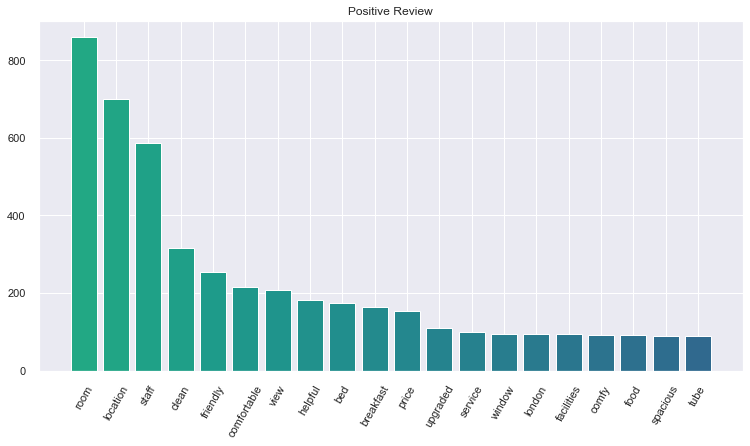

In [261]:
new_figure = plt.figure(figsize=(20,6))
ax2 = new_figure.add_subplot(122)
ax2.bar(positive_bar_words, positive_bar_counts, color=color )
ax2.title.set_text('Positive Review')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)
plt.tight_layout(pad=0)

plt.savefig('../label_word_count.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

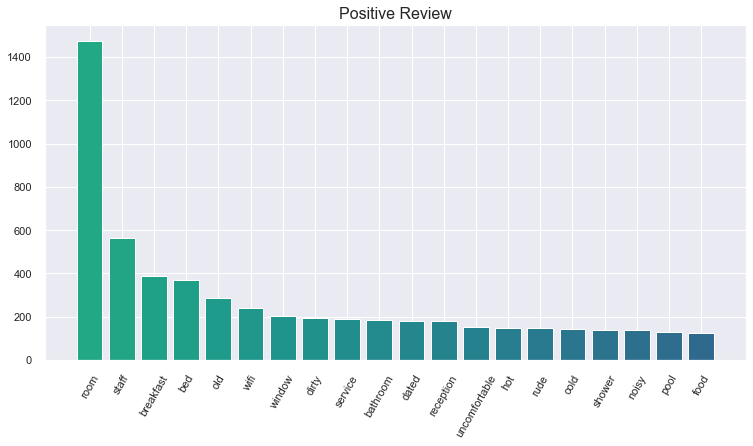

In [262]:
new_figure = plt.figure(figsize=(20,6))
ax2 = new_figure.add_subplot(122)
ax2.bar(negative_bar_words, negative_bar_counts, color=color)
plt.title('Positive Review', fontsize=16)

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)
plt.tight_layout(pad=0)

plt.savefig('../label_word_count.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

## Word Cloud

In [263]:
from wordcloud import WordCloud
negative_dict = dict(zip(negative_bar_words, negative_bar_counts))
positive_dict = dict(zip(positive_bar_words, positive_bar_counts))

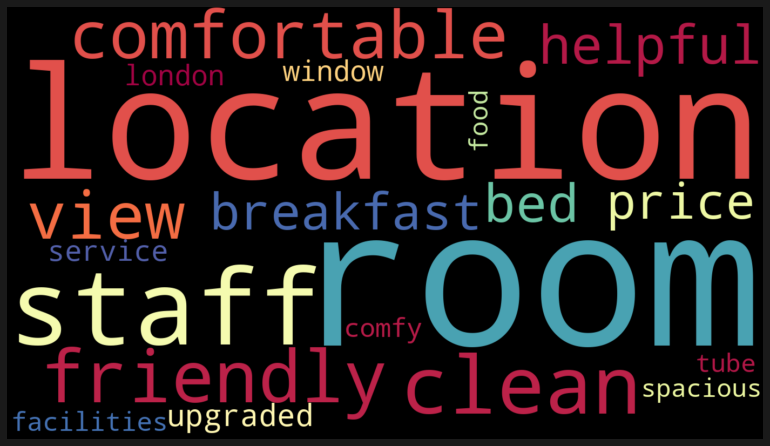

In [264]:
# create the word cloud:
wordcloud = WordCloud(background_color='black', width=1400, height=800, colormap='Spectral').generate_from_frequencies(positive_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(12,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('positive_review_wordcloud.png')

plt.show()

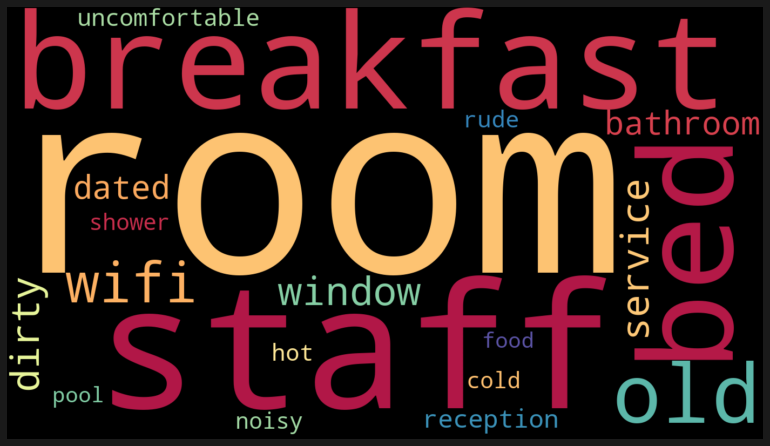

In [265]:
# create the word cloud:
wordcloud = WordCloud(background_color='black', width=1400, height=800, colormap='Spectral').generate_from_frequencies(negative_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(12,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('negative_review_wordcloud.png')

plt.show()

# EDA

## Data Preparation

In [266]:
# Importing DataFrame
df = pd.read_csv('../csv/hotel_review_city_state.csv')

In [267]:
# Choosing features
features = ['Hotel_Name','Review_Date', 'Average_Score',  'Reviewer_Nationality',
'Negative_Review', 'Positive_Review', 'Reviewer_Score','city', 'country']
df = df[features]

In [268]:
df['country'] = df['country'].apply(lambda x: 'Spain' if x == 'España' else 'Austria' if x == 'Österreich' else 'Netherlands' if x == 'Nederland' else x)

In [274]:
df['Reviewer_Nationality'] = df['Reviewer_Nationality'].apply(lambda x: 'USA' if x == 'United States of America' else x)

In [275]:
# Checking DataFrame
df.head(2)

,Hotel_Name,Review_Date,Average_Score,Reviewer_Nationality,Negative_Review,Positive_Review,Reviewer_Score,city,country
0,Hotel Best Western PLUS Alfa Aeropuerto,8/2/2017,7.8,United States of America,The hotel wasn t close to the metro so we had...,Great price for what I got Rooms were extreme...,9.2,Barcelona,Spain
1,Hotel Best Western PLUS Alfa Aeropuerto,8/2/2017,7.8,Bangladesh,Far from the city,Restaurant was cozy Staffs were very friendly...,7.1,Barcelona,Spain


In [276]:
# Hotel DataFrame
hotel = df[df['Hotel_Name']=='Britannia International Hotel Canary Wharf']
london = df[df['city']== 'London']

hotel['Reviewer_Nationality'] = hotel['Reviewer_Nationality'].apply(lambda x: 'USA' if x == 'United States of America' else x)
london['Reviewer_Nationality'] = london['Reviewer_Nationality'].apply(lambda x: 'USA' if x == 'United States of America' else x)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


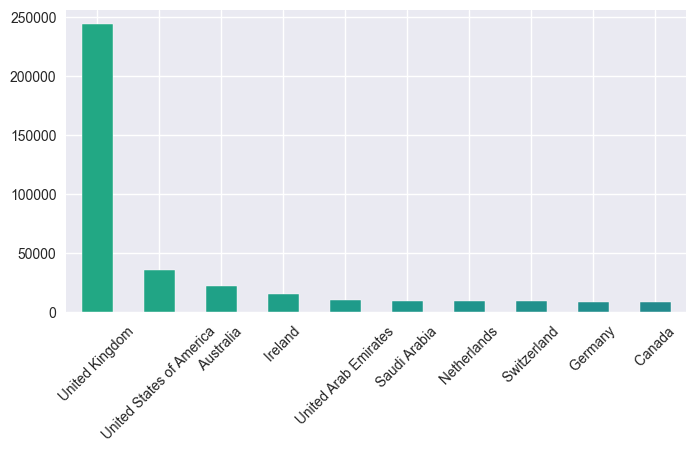

In [277]:
plt.style.use('seaborn')
plt.figure(figsize=(8,4), dpi=100)
df['Reviewer_Nationality'].value_counts().nlargest(10).sort_values(ascending=False).plot(kind='bar', color=color)
plt.xticks(rotation=45)
plt.savefig('filename.png', dpi=300)
plt.show()

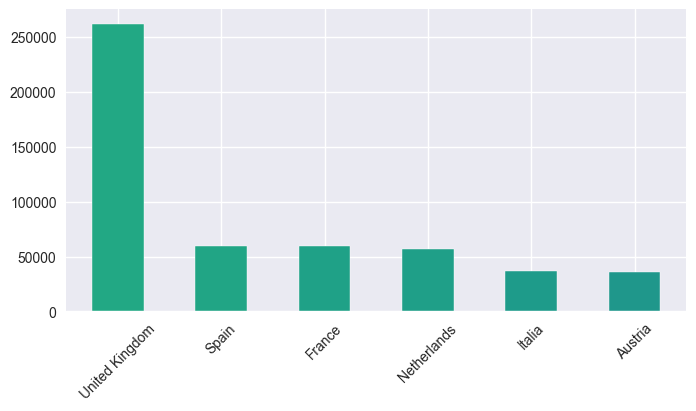

In [278]:
plt.style.use('seaborn')
plt.figure(figsize=(8,4), dpi=100)
df['country'].value_counts().sort_values(ascending=False).plot(kind='bar', color=color)
plt.xticks(rotation=45)
plt.savefig('filename.png', dpi=300)
plt.show()

Text(0, 0.5, 'Density')

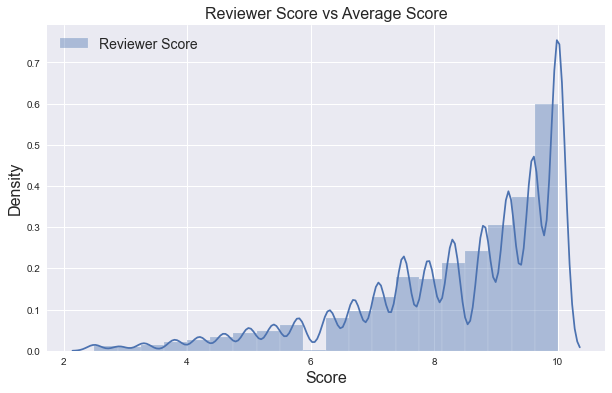

In [279]:
ax = plt.figure(figsize=(10,6))

# sns.distplot(df.Average_Score, label='Average Score')
sns.distplot(df.Reviewer_Score, label='Reviewer Score', bins= 20)
plt.legend(fontsize=14)
plt.title("Reviewer Score vs Average Score", fontsize=16)
plt.xlabel('Score', fontsize=16)
plt.ylabel('Density', fontsize=16)

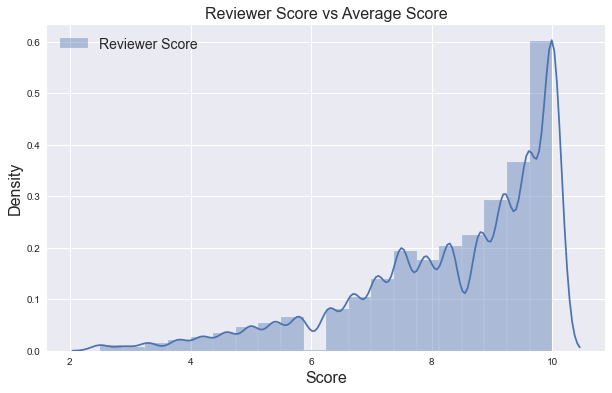

In [280]:
ax = plt.figure(figsize=(10,6))

# sns.distplot(df.Average_Score, label='Average Score')
sns.distplot(london.Reviewer_Score, label='Reviewer Score', bins=20)
plt.legend(fontsize=14)
plt.title("Reviewer Score vs Average Score", fontsize=16)
plt.xlabel('Score', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.show()

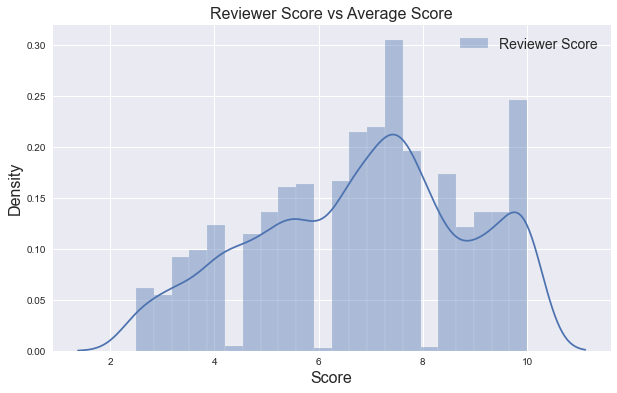

In [281]:
ax = plt.figure(figsize=(10,6))

# sns.distplot(df.Average_Score, label='Average Score')
sns.distplot(hotel.Reviewer_Score, label='Reviewer Score')
plt.legend(fontsize=14)
plt.title("Reviewer Score vs Average Score", fontsize=16)
plt.xlabel('Score', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.show()

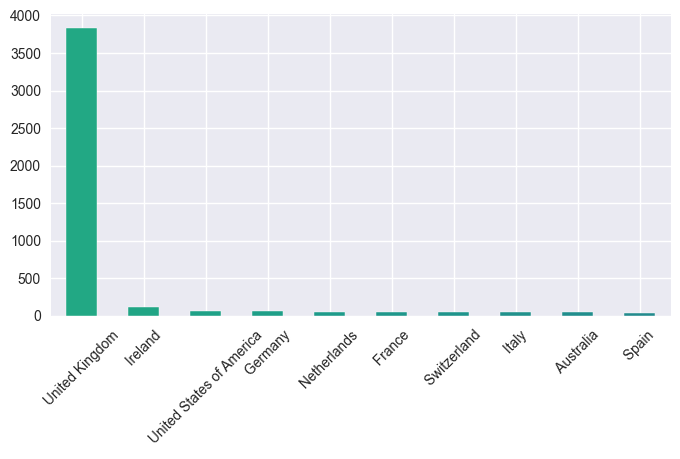

In [282]:
plt.style.use('seaborn')
plt.figure(figsize=(8,4), dpi=100)
hotel['Reviewer_Nationality'].value_counts().nlargest(10).sort_values(ascending=False).plot(kind='bar', color=color)
plt.xticks(rotation=45)
plt.savefig('filename.png', dpi=300)
plt.show()

In [283]:
nationality = london.groupby(['Reviewer_Nationality']).describe()
nationality = nationality['Reviewer_Score']
nationality = nationality.nlargest(15, columns='count')
nationality.reset_index(inplace=True)

x = nationality['Reviewer_Nationality']
y = nationality['mean'].sort_values(ascending=False)

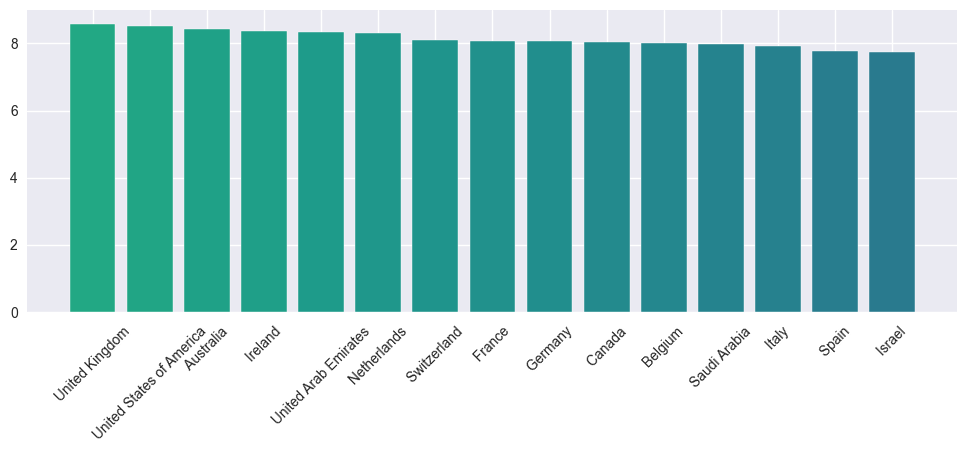

In [284]:
plt.style.use('seaborn')
plt.figure(figsize=(12,4), dpi=100)
plt.bar(x, y, color=color)
plt.xticks(rotation=45)
plt.savefig('filename.png', dpi=300)
plt.show()

In [285]:
nationality = hotel.groupby(['Reviewer_Nationality']).describe()
nationality = nationality['Reviewer_Score']
nationality = nationality.nlargest(15, columns='count')
nationality.reset_index(inplace=True)

x = nationality['Reviewer_Nationality']
y = nationality['mean'].sort_values(ascending=False)

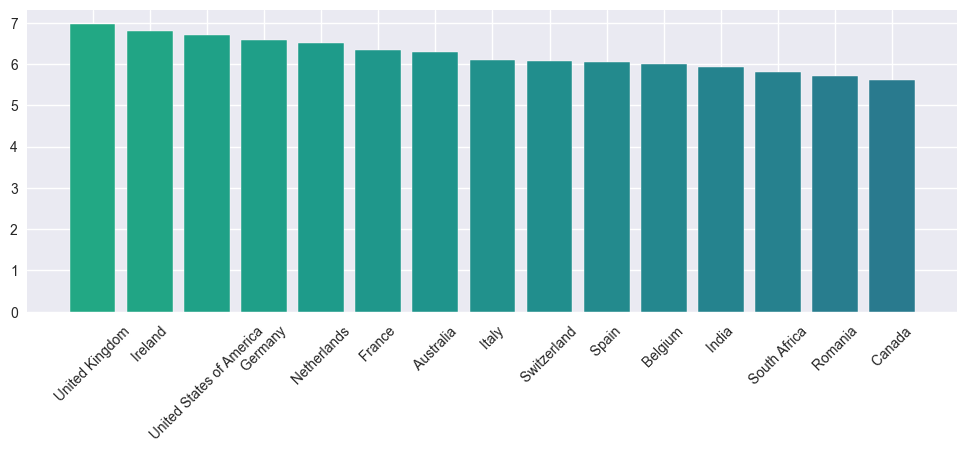

In [286]:
plt.style.use('seaborn')
plt.figure(figsize=(12,4), dpi=100)
plt.bar(x, y, color=color)
plt.xticks(rotation=45)
plt.savefig('filename.png', dpi=300)
plt.show()